<a href="https://colab.research.google.com/github/faizanahemad/eva/blob/master/assignment-4/3rd_Improve_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **3rd File: Improve Training**
    - Adam vs Fine tuned SGD (SGD may be better since recent papers use this)
    - Use ES with validation data. Find right num epochs.
    - Use ReduceLRonPlateau
    - Play with BatchSize
    

**Code for EarlyStopping and Checkpointing:** This is the 1st change we will make to all models
    
    
```python
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping("val_acc",patience=8,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')

callbacks_list = [es,checkpoint]

train_history = model.fit(X_train, Y_train, batch_size=2048, epochs=125, verbose=1, shuffle=True, validation_split=0.1, callbacks=callbacks_list,)


```

**To reload check-pointed Model**

```python
model.load_weights("model.hdf5")
```

In [0]:
!pip install --upgrade --upgrade-strategy only-if-needed https://github.com/faizanahemad/data-science-utils/tarball/master > /dev/null

In [2]:
import pandas as pd
import numpy as np
import time
import gc
import os
import sys
import dill
from matplotlib import pyplot as plt
from keras import backend as K
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.layers import Convolution2D, MaxPooling2D
import warnings
from data_science_utils.vision.keras import *
from keras.layers import Activation
warnings.filterwarnings("ignore")
%matplotlib inline
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import SGD, Nadam, Adam

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Using TensorFlow backend.


In [3]:

X_train, Y_train, X_test, Y_test = get_mnist_data()
print(X_train.shape)
print(X_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)


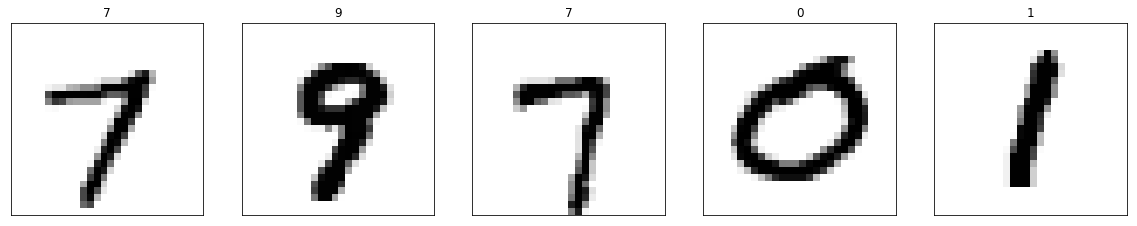

In [4]:
show_examples(X_train[10:15], Y_train[10:15],classes=get_mnist_labels())

## Architecture 3 [Selected]

We tried 32 in 1st layer and then noticed that many of these kernels were empty. So we will use dropout to add more robustness

In [0]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Dropout(0.2))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2))) #12

model.add(Convolution2D(16, 3,3, activation='relu')) # 10
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3, activation='relu')) # 8
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3, activation='relu')) #6
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu')) #6
model.add(Convolution2D(10, 6,6))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.4, patience=5, min_lr=0.0001,verbose=1)
es = EarlyStopping("val_acc",patience=30,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.005,)


model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=2048, epochs=100, verbose=1, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)


## Batch Size vs Accuracy

In [0]:
def run_model(batch_size):
  model = Sequential()
  model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
  model.add(Dropout(0.2))
  model.add(Convolution2D(10, 1, activation='relu'))
  model.add(Convolution2D(16, 3,3, activation='relu')) # 24
  model.add(Dropout(0.1))
  model.add(MaxPooling2D(pool_size=(2, 2))) #12

  model.add(Convolution2D(16, 3,3, activation='relu')) # 10
  model.add(Dropout(0.15))
  model.add(Convolution2D(16, 3,3, activation='relu')) # 8
  model.add(Dropout(0.15))
  model.add(Convolution2D(16, 3,3, activation='relu')) #6
  model.add(Dropout(0.1))
  model.add(Convolution2D(10, 1, activation='relu')) #6
  model.add(Convolution2D(10, 6,6))

  model.add(Flatten())
  model.add(Activation('softmax'))

  reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.4, patience=4, min_lr=0.0001,verbose=0)
  es = EarlyStopping("val_acc",patience=20,restore_best_weights=True)
  checkpoint = ModelCheckpoint("model_2.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
  callbacks_list = [es,checkpoint,reduce_lr]
  optimizer = Adam(lr=0.005,)


  model.compile(loss='categorical_crossentropy',
               optimizer=optimizer,
               metrics=['accuracy'])

  train_history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=60, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
  model.load_weights("model_2.hdf5")

  (_,train_acc),_ = evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=False, plot_results=False)
  (_,test_acc),_ = evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=False, plot_results=False)
  
  return train_acc,test_acc


In [18]:
!pip install tqdm

In [25]:
from tqdm import tnrange, tqdm_notebook

# Code below showed us that batch

batch_to_results = [(int(batch_size),run_model(int(batch_size))) for batch_size in tqdm_notebook(np.linspace(32,4096,50))]


KeyboardInterrupt: ignored

## Trying Optimisers on Arch 3

### AdaBound

- We also tried NAdam and SGD
- SGD was hardest to tune
- Overall Adam always outperforms SGD and other optimisers with little tuning.
- It seems tuning SGD for better than Adam performance needs either lots of hardware or lots of time

In [16]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2))) #12

model.add(Convolution2D(16, 3,3, activation='relu')) # 10
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3, activation='relu')) # 8
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3, activation='relu')) #6
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu')) #6
model.add(Convolution2D(10, 6,6))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.4, patience=5, min_lr=0.0001,verbose=1)
es = EarlyStopping("val_acc",patience=30,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
callbacks_list = [checkpoint]
optimizer = AdaBound(lr=0.001)


model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=2048, epochs=250, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)


Params =  12846
Train on 60000 samples, validate on 10000 samples
Epoch 1/250
60000/60000 [==============================] - 5s 89us/step - loss: 1.9653 - acc: 0.3032 - val_loss: 0.8749 - val_acc: 0.7275
Epoch 2/250
60000/60000 [==============================] - 3s 46us/step - loss: 0.7703 - acc: 0.7638 - val_loss: 0.4460 - val_acc: 0.8742
Epoch 3/250
60000/60000 [==============================] - 3s 45us/step - loss: 0.4690 - acc: 0.8578 - val_loss: 0.3032 - val_acc: 0.9137
Epoch 4/250
60000/60000 [==============================] - 3s 45us/step - loss: 0.3400 - acc: 0.8967 - val_loss: 0.2172 - val_acc: 0.9351
Epoch 5/250
60000/60000 [==============================] - 3s 45us/step - loss: 0.2665 - acc: 0.9181 - val_loss: 0.1763 - val_acc: 0.9468
Epoch 6/250
60000/60000 [==============================] - 3s 45us/step - loss: 0.2177 - acc: 0.9332 - val_loss: 0.1456 - val_acc: 0.9571
Epoch 7/250
60000/60000 [==============================] - 3s 45us/step - loss: 0.1897 - acc: 0.9422 - val

## Architecture 4 [Selected]
- 8->16 architecture
- Low number of Params

In [47]:

model = Sequential()

model.add(Convolution2D(8, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2))) # 12
model.add(Convolution2D(8, 3,3, activation='relu')) # 10
model.add(Convolution2D(16, 3,3, activation='relu')) # 8
model.add(Dropout(0.2))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(Dropout(0.1))
model.add(Convolution2D(16, 3,3, activation='relu')) # 6
model.add(Dropout(0.1))
model.add(Convolution2D(10, 6,6))



model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=0.0002,verbose=1)
es = EarlyStopping("val_acc",patience=18,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.01,)

model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=2048, epochs=50, verbose=1, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)


Params =  10972
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 10s 172us/step - loss: 1.0085 - acc: 0.6752 - val_loss: 0.3141 - val_acc: 0.9069
Epoch 2/50
60000/60000 [==============================] - 1s 25us/step - loss: 0.2749 - acc: 0.9136 - val_loss: 0.1473 - val_acc: 0.9573
Epoch 3/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.1643 - acc: 0.9499 - val_loss: 0.0993 - val_acc: 0.9705
Epoch 4/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.1199 - acc: 0.9633 - val_loss: 0.0700 - val_acc: 0.9791
Epoch 5/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.0951 - acc: 0.9713 - val_loss: 0.0617 - val_acc: 0.9813
Epoch 6/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.0838 - acc: 0.9741 - val_loss: 0.0548 - val_acc: 0.9845
Epoch 7/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.0755 - acc: 0.9764 - val_loss

## Architecture 5 [Selected]

- Underfit
- Less params

In [45]:
model = Sequential()
model.add(Convolution2D(8, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2))) #12
model.add(Convolution2D(10, 1, activation='relu'))

model.add(Convolution2D(16, 3,3, activation='relu')) # 10
model.add(Dropout(0.2))
model.add(Convolution2D(16, 3,3, activation='relu')) # 8
model.add(Dropout(0.2))
model.add(Convolution2D(10, 1, activation='relu')) #8
model.add(Convolution2D(10, 8,8))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.4, patience=4, min_lr=0.0003,verbose=1)
es = EarlyStopping("val_acc",patience=24,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.005,)

model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=2048, epochs=80, verbose=1, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)
# 99.19%

Params =  11774
Train on 60000 samples, validate on 10000 samples
Epoch 1/80
60000/60000 [==============================] - 10s 162us/step - loss: 1.0055 - acc: 0.6969 - val_loss: 0.2717 - val_acc: 0.9236
Epoch 2/80
60000/60000 [==============================] - 2s 26us/step - loss: 0.2365 - acc: 0.9296 - val_loss: 0.1224 - val_acc: 0.9624
Epoch 3/80
60000/60000 [==============================] - 1s 24us/step - loss: 0.1338 - acc: 0.9594 - val_loss: 0.0839 - val_acc: 0.9742
Epoch 4/80
60000/60000 [==============================] - 1s 25us/step - loss: 0.1016 - acc: 0.9688 - val_loss: 0.0596 - val_acc: 0.9804
Epoch 5/80
60000/60000 [==============================] - 1s 24us/step - loss: 0.0814 - acc: 0.9755 - val_loss: 0.0512 - val_acc: 0.9834
Epoch 6/80
60000/60000 [==============================] - 1s 24us/step - loss: 0.0739 - acc: 0.9776 - val_loss: 0.0491 - val_acc: 0.9844
Epoch 7/80
60000/60000 [==============================] - 1s 25us/step - loss: 0.0672 - acc: 0.9790 - val_loss

## Architecture 12 [x]


In [32]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Dropout(0.1))
model.add(Convolution2D(16, 1, activation='relu'))
model.add(Convolution2D(8, (3,3), activation='relu')) # 24
model.add(Convolution2D(16, (3,3), strides=2, activation='relu')) # 11
model.add(Dropout(0.1))
model.add(Convolution2D(8, 1, activation='relu'))
model.add(Convolution2D(16, (3,3), strides=2, activation='relu')) #5
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu')) #3
model.add(Convolution2D(10, 5,5))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())


reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=0.0002,verbose=1)
es = EarlyStopping("val_acc",patience=18,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.005,)

model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=2048, epochs=70, verbose=1, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)
# 99.12%

Params =  7160
Train on 60000 samples, validate on 10000 samples
Epoch 1/70
60000/60000 [==============================] - 8s 135us/step - loss: 1.4532 - acc: 0.4885 - val_loss: 0.4339 - val_acc: 0.8689
Epoch 2/70
60000/60000 [==============================] - 2s 39us/step - loss: 0.3413 - acc: 0.8969 - val_loss: 0.1992 - val_acc: 0.9421
Epoch 3/70
60000/60000 [==============================] - 2s 38us/step - loss: 0.2038 - acc: 0.9386 - val_loss: 0.1294 - val_acc: 0.9620
Epoch 4/70
60000/60000 [==============================] - 2s 38us/step - loss: 0.1564 - acc: 0.9516 - val_loss: 0.1016 - val_acc: 0.9691
Epoch 5/70
60000/60000 [==============================] - 2s 38us/step - loss: 0.1327 - acc: 0.9593 - val_loss: 0.0827 - val_acc: 0.9748
Epoch 6/70
60000/60000 [==============================] - 2s 38us/step - loss: 0.1150 - acc: 0.9647 - val_loss: 0.0752 - val_acc: 0.9773
Epoch 7/70
60000/60000 [==============================] - 2s 38us/step - loss: 0.1038 - acc: 0.9680 - val_loss: 

## Architecture 14 [Selected]
Mixing MaxPool and Strides.
- We presume that MaxPool can be used in early part
- Towards the end we can use Strides=2 which prevents data loss which MaxPool causes, but reduces channel dimensions

In [46]:
model = Sequential()
model.add(Convolution2D(8, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2))) #12
model.add(Convolution2D(10, 1, activation='relu'))
model.add(Dropout(0.1))
model.add(Convolution2D(16, 3,3, activation='relu')) # 10
model.add(Dropout(0.1))
model.add(Convolution2D(16, (3,3,),strides=2, activation='relu')) # 8
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu')) #4
model.add(Convolution2D(10, 4,4))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())


reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, min_lr=0.0001,verbose=1)
es = EarlyStopping("val_acc",patience=24,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.01,)

model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=2048, epochs=80, verbose=1, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)
# 98.89% -> 99.09% -> 99.25%

Params =  6974
Train on 60000 samples, validate on 10000 samples
Epoch 1/80
60000/60000 [==============================] - 10s 169us/step - loss: 0.9058 - acc: 0.6939 - val_loss: 0.2360 - val_acc: 0.9328
Epoch 2/80
60000/60000 [==============================] - 1s 25us/step - loss: 0.2133 - acc: 0.9349 - val_loss: 0.1213 - val_acc: 0.9632
Epoch 3/80
60000/60000 [==============================] - 1s 23us/step - loss: 0.1384 - acc: 0.9584 - val_loss: 0.0828 - val_acc: 0.9734
Epoch 4/80
60000/60000 [==============================] - 1s 23us/step - loss: 0.1102 - acc: 0.9662 - val_loss: 0.0661 - val_acc: 0.9793
Epoch 5/80
60000/60000 [==============================] - 1s 23us/step - loss: 0.0933 - acc: 0.9714 - val_loss: 0.0585 - val_acc: 0.9823
Epoch 6/80
60000/60000 [==============================] - 1s 23us/step - loss: 0.0826 - acc: 0.9747 - val_loss: 0.0573 - val_acc: 0.9830
Epoch 7/80
60000/60000 [==============================] - 1s 24us/step - loss: 0.0763 - acc: 0.9767 - val_loss:

# Misc Code

In [0]:
K.epsilon()

1e-07

In [0]:
layer = model.layers[0]
weights = layer.get_weights()[0]
len(weights)
weights.shape
print()
weights[:,:,:,0]

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 26, 26, 16)        1040      
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 24, 24, 16)        2320      
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 22, 22, 16)        2320      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 11, 11, 16)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 9, 9, 16)          2320      
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 7, 7, 32)          4640      
__________

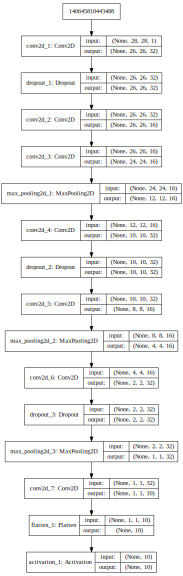

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

m2d = model_to_dot(model, show_shapes=True,)
m2d.set_size('8x18')
SVG(m2d.create(prog='dot', format='svg'))